In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.func import vmap, jacrev
from tqdm import tqdm
import os
import random
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import Callback
import math
from pydmd import DMD
from sklearn.preprocessing import MinMaxScaler
import warnings
from pytorch_lightning.strategies import DDPStrategy
import copy
from matplotlib.colors import LinearSegmentedColormap

In [2]:
class ResidualFlow(nn.Module):
    def __init__(self, dim, hidden_dim, n_layers, input_dim=0, dropout=0, LDJ=False):
        super(ResidualFlow, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.LDJ = LDJ
        self.dropout = dropout
        
        layers = [nn.Linear(self.dim+self.input_dim, self.hidden_dim), nn.ReLU()]
        for _ in range(self.n_layers):
            layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(self.hidden_dim, self.dim))
        self.net = nn.Sequential(*layers)
        self._initialize_weights()
    
    def forward(self, x, u=None, reverse=False):
        def func(x_):
            x_e = torch.cat((x_, u), dim=-1) if u is not None else x_
            return self.net(x_e)
        if not reverse:   
            y = x + func(x)
            if self.LDJ:
                x = x.view(-1, x.shape[-1])
                jacobian = vmap(jacrev(func))(x)
                jacobian = jacobian.clone()  
                jacobian.diagonal(dim1=-2, dim2=-1).add_(1.0)
                _, logdet = torch.linalg.slogdet(jacobian)
                logdet = logdet.sum()
            else:
                logdet = 0
            return y, logdet
        else:
            y = x
            epsilon = 1e-8
            det = 1
            max_iter = 9999
            with torch.no_grad():
                for _ in range(max_iter):
                    y_temp = y
                    y = x - func(y)
                    det = torch.norm(y - y_temp, dim=-1).max()
                    if det < epsilon:
                        break  
            return y
    
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):  
                nn.init.xavier_uniform_(module.weight) 
                if module.bias is not None:
                    nn.init.zeros_(module.bias) 

class InvertibleNN(nn.Module):
    def __init__(self, dim, hidden_dim, n_blocks, n_layers, input_dim=0, dropout=0, LDJ=False):
        super(InvertibleNN, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.blocks = nn.ModuleList([ResidualFlow(self.dim, self.hidden_dim, self.n_layers, self.input_dim, dropout, LDJ) for _ in range(self.n_blocks)])
    
    def forward(self, x, u=None, reverse=False):
        if not reverse:
            ldj_total = 0
            for block in self.blocks:
                x, ldj = block(x, u, reverse)
                ldj_total += ldj
            return x, ldj_total
        else:
            for block in reversed(self.blocks):
                x = block(x, u, reverse)
            return x
    
class CombinedNetwork(nn.Module):
    def __init__(self, inn_model, input_dim, lifted_dim, Xmax, Xmin):
        super(CombinedNetwork, self).__init__()
        self.input_dim = input_dim
        self.inn_model = inn_model  
        self.Xmax = Xmax
        self.Xmin = Xmin
        self.dropout = nn.Dropout(p=inn_model.blocks[0].dropout)
        self.linear = nn.Linear(input_dim, lifted_dim, bias=False)  
        self._initialize_weights()
    
    def forward(self, x, u=None, reverse=False):
        x = x.float()
        Xmax = self.Xmax.to(x.device)
        Xmin = self.Xmin.to(x.device)
        if not reverse:
            x = (x - Xmin) / (Xmax - Xmin)
            chebyshev = torch.cos(self.linear(torch.arccos(x)))
            x = torch.cat((x, chebyshev), dim=-1)
            # x = self.dropout(x)
            x, ldj = self.inn_model(x, u, reverse)
            return x, ldj
        else:
            x = self.inn_model(x, u, reverse)
            x = x[:, :self.input_dim]
            x = (Xmax - Xmin) * x + Xmin
            return x
    
    def _initialize_weights(self):
        lambda_s = 5
        self.linear.weight.data = torch.distributions.exponential.Exponential(lambda_s).sample(self.linear.weight.shape)
        
class KoopmanModule(nn.Module):
    def __init__(self, g_model, latent_dim, K_init=None):
        super().__init__()
        self.g_model = g_model
        self.latent_dim = latent_dim
        self.K = nn.Parameter(torch.randn(latent_dim, latent_dim), requires_grad=True)
        self.K.data.copy_(K_init)

    def forward(self, x: torch.Tensor, reverse: bool = False) -> torch.Tensor:
        return self.g_model(x, reverse=reverse)[0]

In [3]:
class TrainModel(pl.LightningModule):
    def __init__(self, model, rank, learning_rate=1e-3, lamb=1, path="model_checkpoint_Van"):
        super(TrainModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()
        self.best_val_loss = float('inf')  
        self.validation_outputs = []
        self.lamb = lamb
        self.train_losses = []
        self.rank = rank
        self.path = path+'.ckpt'

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X_batch = batch[0]
        GY, GY_pred, ldj = dmd(self.model, X_batch, self.rank)

        loss_lin = self.criterion(GY, GY_pred)
        loss_LDJ = ldj / X_batch.numel()

        loss = loss_lin - self.lamb * loss_LDJ
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        Z_batch = batch[0]
        Z1, Z_pred, _ = dmd(self.model, Z_batch, self.rank)
        Z_pred = self.model(Z_pred.T, reverse=True)
        Z1 = self.model(Z1.T, reverse=True)
        valid_loss = self.criterion(Z_pred, Z1)

        self.validation_outputs.append(valid_loss)
        self.log('val_loss', valid_loss)
        return valid_loss

    def test_step(self, batch, batch_idx):
        Z_batch = batch[0]
        Z1, Z_pred, _ = dmd(self.model, Z_batch, self.rank)
        Z_pred = self.model(Z_pred.T, reverse=True)
        Z1 = self.model(Z1.T, reverse=True)
        test_loss = self.criterion(Z_pred, Z1)

        self.log('test_loss', test_loss)
        return test_loss
    
    def on_fit_start(self):
        if self.trainer.is_global_zero: 
            if os.path.exists("loss_log.txt"):
                os.remove("loss_log.txt")
            if os.path.exists(self.path):
                os.remove(self.path)
    
    def on_train_batch_end(self, outputs, batch, batch_idx):
        with torch.no_grad():  
            for name, module in self.model.named_modules():  
                if isinstance(module, nn.Linear): 
                    if name == "linear":  
                        continue
                    weight = module.weight  
                    sigma_max = torch.norm(weight, p=2)  
                    if sigma_max > 1:  
                        scale = (1 - 1e-3) / sigma_max
                        module.weight.data *= scale  
    
    def on_train_epoch_start(self):
        if os.path.exists(self.path):
            best_state_dict = torch.load(self.path)["state_dict"]
            self.load_state_dict(best_state_dict)
    
    def on_train_epoch_end(self):
        if self.trainer.is_global_zero: 
            avg_train_loss = self.trainer.callback_metrics.get("train_loss")
            if avg_train_loss is not None:
                self.train_losses.append(avg_train_loss.item())  
                print(f"Epoch {self.current_epoch}: Average Training Loss = {avg_train_loss.item()}")

    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.validation_outputs).mean()
        self.log('avg_val_loss', avg_val_loss)
        self.validation_outputs.clear()
        print(f"Validation loss: {avg_val_loss}")
        with open("loss_log.txt", "a") as f:
            f.write(f"{avg_val_loss.item()}\n")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, eps=1e-08,
                                            weight_decay=0)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=1,
            gamma=0.92
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",  
            },
            "gradient_clip_val": 1.0,  
            "gradient_clip_algorithm": "norm",
        }

In [4]:
def load_model_and_K(model_class, K_path, model_path, device="cpu", **model_kwargs):
    g_model = model_class(**model_kwargs).to(device)
    g_model.load_state_dict(torch.load(model_path, map_location=device))
    g_model.eval()

    K = torch.load(K_path, map_location=device)

    print(f"Loaded g_model from {model_path}")
    print(f"Loaded Koopman operator K from {K_path}")

    return g_model, K

In [5]:
dim = 50  
hidden_dim = 100 
input_dim = 0
n_blocks = 3  
n_layers = 1
n_feature = 0
rank = 10
batch_size = 99999
n_train = 2000
n_valid = 200
n_test = 200
dropout = 0.5
num_epochs = 1000 
lamb = 0
learning_rate = 0 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
X_train = pd.read_csv('SG_train.csv', header=None).values
X_valid = pd.read_csv('SG_valid.csv', header=None).values
X_test = pd.read_csv('SG_test.csv', header=None).values

length = X_train.shape[1] // n_train
H_train = []
for i in range(n_train):
    H_train.append(X_train[:, i*length:(i+1)*length])
H_train = np.stack([H_train[idx].T for idx in range(n_train)], axis=0)
H_valid = []
for i in range(n_valid):
    H_valid.append(X_valid[:, i*length:(i+1)*length])
H_valid = np.stack([H_valid[idx].T for idx in range(n_valid)], axis=0)
train_dataset = TensorDataset(torch.tensor(H_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_dataset = TensorDataset(torch.tensor(H_valid))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

X_result = np.concatenate([X_train, X_test, X_valid], axis=-1)
Xmax = torch.tensor(np.max(X_result, axis=-1), dtype=torch.float)
Xmin = torch.tensor(np.min(X_result, axis=-1), dtype=torch.float)

In [7]:
inn_model = InvertibleNN(
    dim=dim + n_feature,
    hidden_dim=hidden_dim,
    n_blocks=n_blocks,
    n_layers=n_layers,
    input_dim=input_dim,
    dropout=dropout,
    LDJ=lamb > 0
)

model = CombinedNetwork(
    inn_model=inn_model,
    input_dim=dim,
    lifted_dim=n_feature,
    Xmax=Xmax,
    Xmin=Xmin
)

g_model, K = load_model_and_K(
    model_class=CombinedNetwork,
    K_path="SG_K.pt",
    model_path="SG.pth",
    device="cuda" if torch.cuda.is_available() else "cpu",
    inn_model=inn_model,
    input_dim=dim,
    lifted_dim=n_feature,
    Xmax=Xmax,
    Xmin=Xmin
)

/opt/conda/lib/python3.11/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Loaded g_model from SG.pth
Loaded Koopman operator K from SG_K.pt


/tmp/ipykernel_2848/855383640.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g_model.load_state_dict(torch.load(model_path, map_location=device))
/tmp/ipykernel_2848/85

In [8]:
device = next(g_model.parameters()).device
GX = g_model(torch.tensor(H_train[:, :-1, :], dtype=torch.float32).to(device))[0]
GY = g_model(torch.tensor(H_train[:, 1:, :], dtype=torch.float32).to(device))[0]
X_all = GX.reshape(-1, dim+n_feature) 
Y_all = GY.reshape(-1, dim+n_feature)  

In [9]:
GY_pred = GX @ K
Y_pred = g_model(GY_pred.reshape(-1, GY_pred.shape[-1]), reverse=True).cpu()
Y = torch.tensor(H_train[:, 1:, :].reshape(-1, H_train.shape[-1]), dtype=torch.float32).to(device).cpu()
nn.MSELoss()(Y, Y_pred)

tensor(0.0001)

In [10]:
eigvals, eigvecs = torch.linalg.eig(K)
abs_eigvals = eigvals.abs()
sorted_indices = torch.argsort(abs_eigvals, descending=True)
eigvals_sorted = eigvals[sorted_indices]  
eigvecs_sorted = eigvecs[:, sorted_indices] 

In [11]:
eigvals_sorted

tensor([ 1.0003e+00+0.0000e+00j,  9.1517e-01+0.0000e+00j,
         1.3574e-01+0.0000e+00j, -1.1874e-01+0.0000e+00j,
         4.0122e-02+0.0000e+00j,  3.5158e-02+1.6073e-03j,
         3.5158e-02-1.6073e-03j,  3.2857e-02+1.2847e-03j,
         3.2857e-02-1.2847e-03j,  3.2796e-02+3.8486e-04j,
         3.2796e-02-3.8486e-04j,  3.1858e-02+7.6111e-05j,
         3.1858e-02-7.6111e-05j,  3.1660e-02+1.8960e-03j,
         3.1660e-02-1.8960e-03j,  3.1564e-02+2.6897e-04j,
         3.1564e-02-2.6897e-04j,  3.0596e-02+0.0000e+00j,
         2.8938e-02+6.6792e-03j,  2.8938e-02-6.6792e-03j,
         2.9453e-02+0.0000e+00j,  2.8778e-02+0.0000e+00j,
         1.3155e-02+1.9832e-02j,  1.3155e-02-1.9832e-02j,
         2.0413e-02+0.0000e+00j, -1.5303e-02+0.0000e+00j,
         8.1932e-03+3.5239e-03j,  8.1932e-03-3.5239e-03j,
        -2.5997e-03+7.4412e-03j, -2.5997e-03-7.4412e-03j,
        -1.7657e-03+2.9315e-03j, -1.7657e-03-2.9315e-03j,
         1.6613e-03+0.0000e+00j, -1.5310e-03+0.0000e+00j,
         1.304

In [29]:
GX_all = g_model(torch.tensor(H_train[18, :, :], dtype=torch.float32).to(device))[0].reshape(-1, dim+n_feature)
X_all = X_train[:, 18*50:19*50].T
phi = GX_all.to(torch.complex64) @ eigvecs_sorted
magnitude = torch.abs(phi).cpu().detach().numpy()
phase = torch.angle(phi).cpu().detach().numpy()

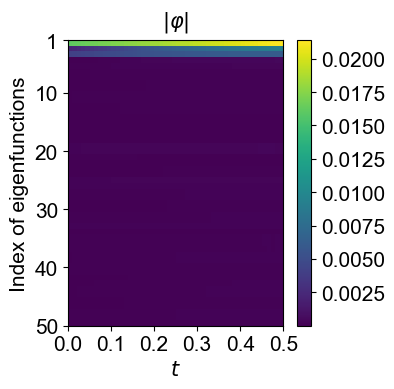

In [40]:
from matplotlib.font_manager import FontProperties

arial_font = FontProperties(fname="/root/.fonts/arial.ttf", size=15)

x = np.linspace(1, 50, 50)   
t = np.linspace(0, 0.5, 50)

plt.figure(figsize=(4, 4))

im = plt.imshow(
    magnitude.T,
    extent=[t.min(), t.max(), x.min(), x.max()],
    aspect='auto',
    origin='lower',
    cmap='viridis'  
)

plt.title("$\\vert\\varphi\\vert$", fontsize=15, fontproperties=arial_font, pad=10)

plt.xlabel("$t$", fontsize=15, fontproperties=arial_font)
plt.ylabel("Index of eigenfunctions", fontsize=15, fontproperties=arial_font)
plt.xticks(fontsize=8, fontproperties=arial_font)
plt.yticks([1, 10, 20, 30, 40, 50], fontsize=8, fontproperties=arial_font)
plt.gca().invert_yaxis()

cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=8)
for l in cbar.ax.get_yticklabels():
    l.set_fontproperties(arial_font)

plt.tight_layout()
plt.savefig("SG1.svg", format='svg', bbox_inches='tight')
plt.show()

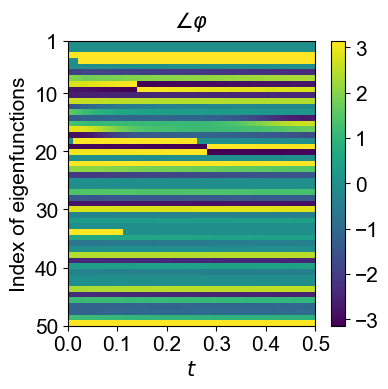

In [41]:
from matplotlib.font_manager import FontProperties

arial_font = FontProperties(fname="/root/.fonts/arial.ttf", size=15)

x = np.linspace(1, 50, 50)     
t = np.linspace(0, 0.5, 50)

plt.figure(figsize=(4, 4))

im = plt.imshow(
    phase.T,
    extent=[t.min(), t.max(), x.min(), x.max()],
    aspect='auto',
    origin='lower',
    cmap='viridis'  
)

plt.title("$\\angle\\varphi$", fontsize=15, fontproperties=arial_font, pad=10)

plt.xlabel("$t$", fontsize=15, fontproperties=arial_font)
plt.ylabel("Index of eigenfunctions", fontsize=15, fontproperties=arial_font)
plt.xticks(fontsize=8, fontproperties=arial_font)
plt.yticks([1, 10, 20, 30, 40, 50], fontsize=8, fontproperties=arial_font)
plt.gca().invert_yaxis()

cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=8)
for l in cbar.ax.get_yticklabels():
    l.set_fontproperties(arial_font)

plt.tight_layout()
plt.savefig("SG2.svg", format='svg', bbox_inches='tight')
plt.show()

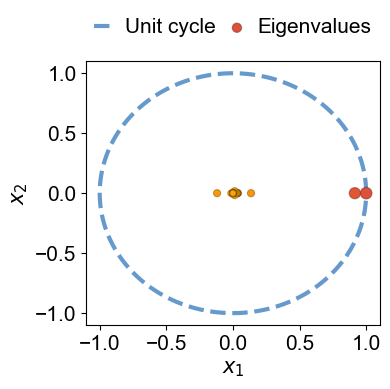

In [42]:
eigs = eigvals_sorted.cpu().detach().numpy()

arial_font = FontProperties(fname="/root/.fonts/arial.ttf", size=15)

theta = np.linspace(0, 2 * np.pi, 500)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)

modulus = np.abs(eigs)
norm_modulus = (modulus - modulus.min()) / (modulus.max() - modulus.min())
sizes = 20 + 50 * norm_modulus

base_cmap = plt.cm.inferno
det = 0.2
light_cmap = LinearSegmentedColormap.from_list(
    "inferno", base_cmap(np.linspace(1.0 - det, 0.8 - det, 256))
)

face_colors = light_cmap(norm_modulus)

def mix_with_white(rgb_array, ratio=0.5):
    white = np.zeros_like(rgb_array)
    return rgb_array * (1 - ratio) + white * ratio

edge_colors = mix_with_white(face_colors, ratio=0.5)

plt.figure(figsize=(4, 4))
plt.plot(unit_circle_x, unit_circle_y, linestyle='--', color="#6699CC", zorder=1, linewidth=3, label='Unit cycle')

scatter = plt.scatter(
    eigs.real,
    eigs.imag,
    c=face_colors,          
    s=sizes,
    edgecolors=edge_colors, 
    linewidth=0.8,
    zorder=2,
    label='Eigenvalues'
)


plt.legend(loc='lower center',
    bbox_to_anchor=(0.5, 1.02),borderaxespad=0.5, columnspacing=0.5,
    handletextpad=0.5,
    handlelength=1,
    ncol=3,frameon=False, prop=arial_font)
plt.grid(False)
plt.title("")
plt.xlabel("$x_1$", fontsize=15, fontproperties=arial_font)
plt.ylabel("$x_2$", fontsize=15, fontproperties=arial_font)
plt.xticks(fontsize=8, fontproperties=arial_font)
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0], fontsize=8, fontproperties=arial_font)

plt.tight_layout()
plt.savefig("SG3.svg", format='svg', bbox_inches='tight')
plt.show()